In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import imageio
from PIL import Image
import json
from scipy.spatial import Delaunay
import skimage as ski
import einops

def read_img(img_name, img_dir = 'in_dir/', grayscale=False):
    if '.' not in img_name:
        img_name += '.jpg'
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img)
    img = img / 255
    return img
images_out = 'images_out/' 
def save_img(fname, img_out, out_dir = images_out, grayscale=False):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img_out = np.clip(img_out, a_min=0, a_max=1)
    # img_out = (img_out*255).astype(np.uint8)
    if grayscale:
        imageio.imwrite(full_name, img_out)
    else:
        plt.imsave(full_name, img_out)

In [497]:
# Computes the homography p’=Hp, where H
# is a 3x3 matrix with 8 degrees of freedom
def compute_h(img_1_pts, img_2_pts):
    assert len(img_1_pts) == len(img_2_pts)
    n = len(img_1_pts)
    img_1_pts = np.asarray(img_1_pts)
    img_1_hom = to_homogenous(img_1_pts)
    img_2_pts = np.asarray(img_2_pts)
    img_2_pts_flat = np.ndarray.flatten(img_2_pts)
    
    len_H = 8
    A = np.zeros((2*n, len_H))

    A[0:-1:2, :3] = img_1_hom.T # Set first 3 columns with p
    A[1::2, 3:6] = img_1_hom.T  # Set columns 3-5 with p

    # Set end columns with p
    A[::2, -2:] = img_1_pts 
    A[1::2, -2:] = img_1_pts 

    # Multiply end columns with p'
    A[:, -2] *= -img_2_pts_flat
    A[:, -1] *= -img_2_pts_flat
    b = img_2_pts_flat
    x, res, rank, _ = np.linalg.lstsq(A, b, rcond=None)
    H = np.ones(9)
    H[:8] = x
    H = np.reshape(H, (3,3))
    return H, res, rank
# Adds ones on axis 1
def to_homogenous(inp):
    inp = np.asarray(inp)
    ones = np.ones((inp.shape[0],1))
    return np.concatenate((inp, ones), axis=1).T

# Takes homogenous points and returns normal
def homogenous_to_non(inp):
    inp = np.asarray(inp)
    z = inp[-1, :]
    inp = inp[:-1, :] / z
    return inp.T

# Applies homography to non-homogenous coordinate inp, returning the new coords
# also in non-homogenous form
def apply_h(h, inp):
    homo = to_homogenous(inp)
    transformed = h @ homo
    return homogenous_to_non(transformed)

def get_corners(img):
    img_corners = [[img.shape[1], img.shape[0]], [img.shape[1], 0], [0,0], [0, img.shape[0]]]
    return img_corners

def get_inv(A):
    return np.linalg.inv(A)

# Takes in non-homogenous points
def create_polygon(points):
    points = np.asarray(points)
    cc, rr = ski.draw.polygon(points[:,0], points[:,1], shape=None)
    return cc,rr

In [498]:
### Tests to confirm homography calculated correctly
img_1_pts = [[6,1], [2,4], [3,7], [5,4]]
img_1_pts = np.asarray(img_1_pts)
img_1_hom = to_homogenous(img_1_pts)
ans = compute_h(img_1_pts, img_1_pts)
H = ans[0]
after_H = H @ img_1_hom
assert np.all(np.isclose(img_1_hom, after_H))

H = [[10,4,6],
     [2.3,4.3,-4],
     [0, 0, 1]]
img_2_hom = H @ img_1_hom
img_2_normal = homogenous_to_non(img_2_hom)
ans = compute_h(img_1_pts, img_2_normal)
H_computed = ans[0]
assert np.all(np.isclose(H, H_computed))

In [605]:
def load_corr_pts(fname, in_dir='images_in/', single=True):
    if 'json' not in fname: fname += '.json'
    corr_file = in_dir + fname
    f = open(corr_file)
    correspondences = json.load(f)
    img_1_points = np.array(correspondences['im1Points'])
    img_2_points = np.array(correspondences['im2Points'])
    if single:
        return img_1_points
    else:
        return img_1_points, img_2_points

def plot_pts(pts, color='blue'):
    x, y = pts[:, 0], pts[:, 1]
    [plt.text(x[i], y[i], f'{i}', fontsize=10, ha='right', color=color) for i in range(len(x))]
    plt.scatter(x,y, color=color, s=5)

In [620]:
# Sets up img for interpolation
def create_interp_grid(img):
    X, Y = np.mgrid[:img.shape[0], :img.shape[1]]
    points = np.dstack((X.ravel(), Y.ravel())).squeeze()
    # Flatten img to use for interpolation
    flat_img = einops.rearrange(img, ('h w c -> (h w) c'))
    color_interp = scipy.interpolate.NearestNDInterpolator(points, flat_img)
    return color_interp

# Applies homography to img
def warp(H, img, color_interp=None, out_dir='images_out/part_a/part_2/', fname=None):
    new_image = np.zeros(img.shape)
    cc, rr = create_polygon(get_corners(img))
    src_coords = np.array([cc, rr, np.ones_like(rr)])

    new = homogenous_to_non(get_inv(H) @ src_coords)   # Apply transformation to get pts in original image
    c_n, r_n = new[:, 0], new[:, 1]
    rr = np.clip(rr, 0, new_image.shape[0]-1)
    cc = np.clip(cc, 0, new_image.shape[1]-1)

    # Interpolate at to get the colors of the points when inv mapped
    mask_c = c_n < img.shape[1]
    mask_c *= c_n >= 0
    mask_c = np.repeat(mask_c[:, np.newaxis], 3, axis=1)

    mask_r = r_n < img.shape[0]
    mask_r *= r_n >= 0
    mask_r = np.repeat(mask_r[:, np.newaxis], 3, axis=1)
    # mask = mask_r * mask_c

    if color_interp == None:
        color_interp = create_interp_grid(img)
    tri_interp = color_interp((r_n, c_n))
    tri_interp_mask_c = np.where(mask_c, tri_interp, np.ones(3))
    tri_interp_mask_rc = np.where(mask_r, tri_interp_mask_c, np.ones(3))

    # new_image[rr, cc] = tri_interp
    new_image[rr, cc] = tri_interp_mask_rc
    plt.imshow(new_image)
    if fname != None:
        save_img(fname, new_image, out_dir=out_dir)
    return new_image

In [577]:
def get_pts_from_corner(top_left, bottom_right):
    h, w = -top_left[1] + bottom_right[1], bottom_right[0] - top_left[0]
    top_right = bottom_right[0], bottom_right[1] - h
    bottom_left = bottom_right[0] - w, bottom_right[1]
    return np.asarray([top_left, bottom_left, bottom_right, top_right])

In [574]:
img_dir = 'images_in/'

macbook_pts = load_corr_pts('macbook', single=True)
img = read_img('macbook', img_dir)


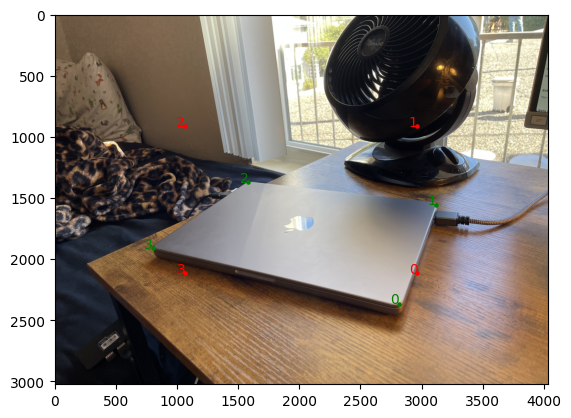

In [621]:
w, h = 950, 600
x, y = 2016, 1512
target_pts = np.asarray([[x+w,y+h], [x+w,y-h], [x-w,y-h], [x-w,y+h]])
# img_2_points = get_corners(img)

plot_pts(macbook_pts, color='green')
plot_pts(target_pts, color='red')
H, _, _ = compute_h(macbook_pts, target_pts)

plt.imshow(img)

In [622]:
macbook_interp = create_interp_grid(img)

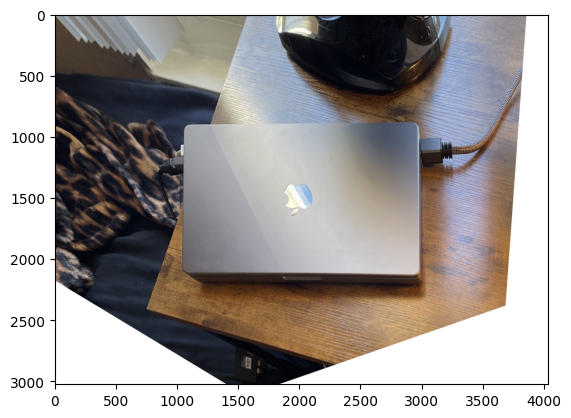

In [623]:
target_pts = np.asarray([[x+w,y+h], [x+w,y-h], [x-w,y-h], [x-w,y+h]])
H, _, _ = compute_h(macbook_pts, target_pts)
mac_rectified = warp(H, img, macbook_interp, fname='macbook')

[[1408  837]
 [1404 1636]
 [3094 1653]
 [3086 1118]]


(3024, 4032, 3)

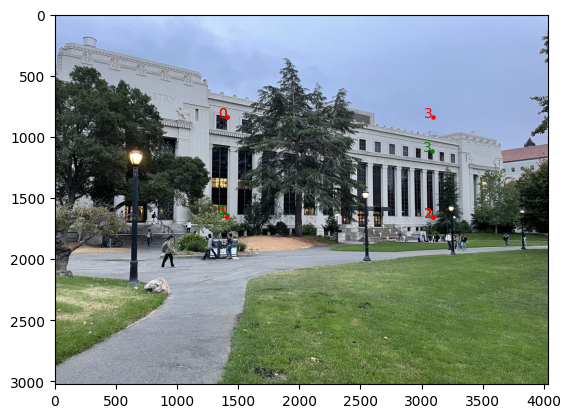

In [607]:
vlsb_pts = load_corr_pts('vlsb', single=True)
vlsb = read_img('vlsb_horizontal', img_dir)
target_pts = get_pts_from_corner(vlsb_pts[0], vlsb_pts[-1])
plt.imshow(vlsb)
vlsb_pts_4 = np.asarray([vlsb_pts[0,:], vlsb_pts[3,:], vlsb_pts[-1,:], vlsb_pts[4,:]])
plot_pts(vlsb_pts_4, color='green')
plot_pts(target_pts, color='red')
vlsb.shape

In [586]:
vlsb_interp = create_interp_grid(vlsb)

In [608]:
H, _, _ = compute_h(vlsb_pts_4, target_pts)

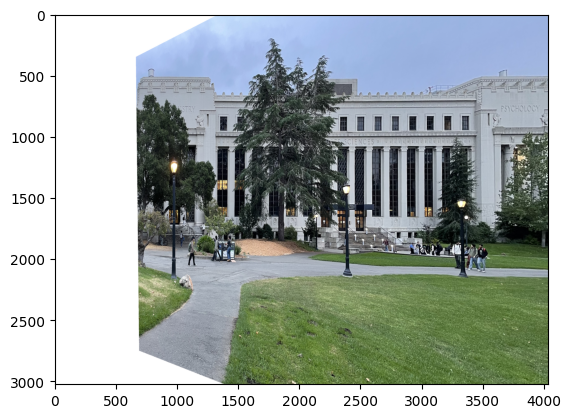

In [614]:
warp(H, vlsb, vlsb_interp)